In [1]:
import numpy as np
import vtk
from vtk.util import numpy_support as vtk_np


def pvti_readin(filename):
    '''
    Reads in data from pvti with filename, use this to read in electron number density data

    '''

    reader = vtk.vtkXMLPImageDataReader()
    reader.SetFileName(filename)
    reader.Update()

    data = reader.GetOutput()
    dim = data.GetDimensions()
    spacing = np.array(data.GetSpacing())

    v = vtk_np.vtk_to_numpy(data.GetCellData().GetArray(0))
    n_comp = data.GetCellData().GetArray(0).GetNumberOfComponents()

    vec = [int(i-1) for i in dim]

    if(n_comp > 1):
        vec.append(n_comp)

    if(n_comp > 2):
        img = v.reshape(vec,order="F")[0:dim[0]-1,0:dim[1]-1,0:dim[2]-1,:]
    else:
        img = v.reshape(vec,order="F")[0:dim[0]-1,0:dim[1]-1,0:dim[2]-1]

    dim = img.shape

    return img,dim,spacing

# data, dim, spacing = pvti_readin('/rds/general/user/le322/home/synthPy/run_scripts/fields/sim_fields/radmeshablation_3d_prp_CH_ne_lvl6_dims512x512x512.pvti')

In [43]:
import numpy as np
import yt
import sys
import matplotlib.pyplot as plt
ds = yt.load('/rds/general/user/le322/home/synthPy/radmeshablation_3d_prp_CH_hdf5_plt_cnt_0014')

def _ne(field, data):
    return (
        6.022e23
        * data["flash", "dens"]
        * data["flash", "ye"]
        * data["flash", "sumy"] #sumy is inverse of mean molecular mass
    )

ds.add_field(
    name=("flash","ne"),
    function=_ne,
    sampling_type="local",
    units="code_mass/code_length**3",
    force_override=False
)

level = ds.index.max_level
dims = ds.domain_dimensions * ds.refine_by**level
cube = ds.covering_grid(level, left_edge=ds.domain_left_edge, dims=dims)
ne   = cube[("flash","ne")]
spacing = [(ds.domain_right_edge[i] - ds.domain_left_edge[i]) / dims[i] for i in range(len(dims))]


yt : [INFO     ] 2024-08-02 15:49:56,683 Parameters: current_time              = 3.3046346101614595e-07
yt : [INFO     ] 2024-08-02 15:49:56,684 Parameters: domain_dimensions         = [8 8 8]
yt : [INFO     ] 2024-08-02 15:49:56,685 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-08-02 15:49:56,685 Parameters: domain_right_edge         = [2. 3. 2.]
yt : [INFO     ] 2024-08-02 15:49:56,686 Parameters: cosmological_simulation   = 0


In [44]:

proj= []
frm           =  yt.ProjectionPlot(ds,'y', ("flash", "ne"))
proj_frm       =  frm.data_source.to_frb([(2, "cm"),(2, "cm")], 2000)
proj.append(np.array(proj_frm[('gas','El_number_density')]))

yt : [INFO     ] 2024-08-02 15:54:21,728 Projection completed
yt : [INFO     ] 2024-08-02 15:54:21,730 xlim = 0.000000 2.000000
yt : [INFO     ] 2024-08-02 15:54:21,730 ylim = 0.000000 2.000000
yt : [INFO     ] 2024-08-02 15:54:21,732 xlim = 0.000000 2.000000
yt : [INFO     ] 2024-08-02 15:54:21,733 ylim = 0.000000 2.000000
yt : [INFO     ] 2024-08-02 15:54:21,734 Making a fixed resolution buffer of (('flash', 'ne')) 800 by 800
yt : [INFO     ] 2024-08-02 15:54:21,942 Making a fixed resolution buffer of (('gas', 'El_number_density')) 2000 by 2000
yt : [INFO     ] 2024-08-02 15:54:24,295 Projection completed



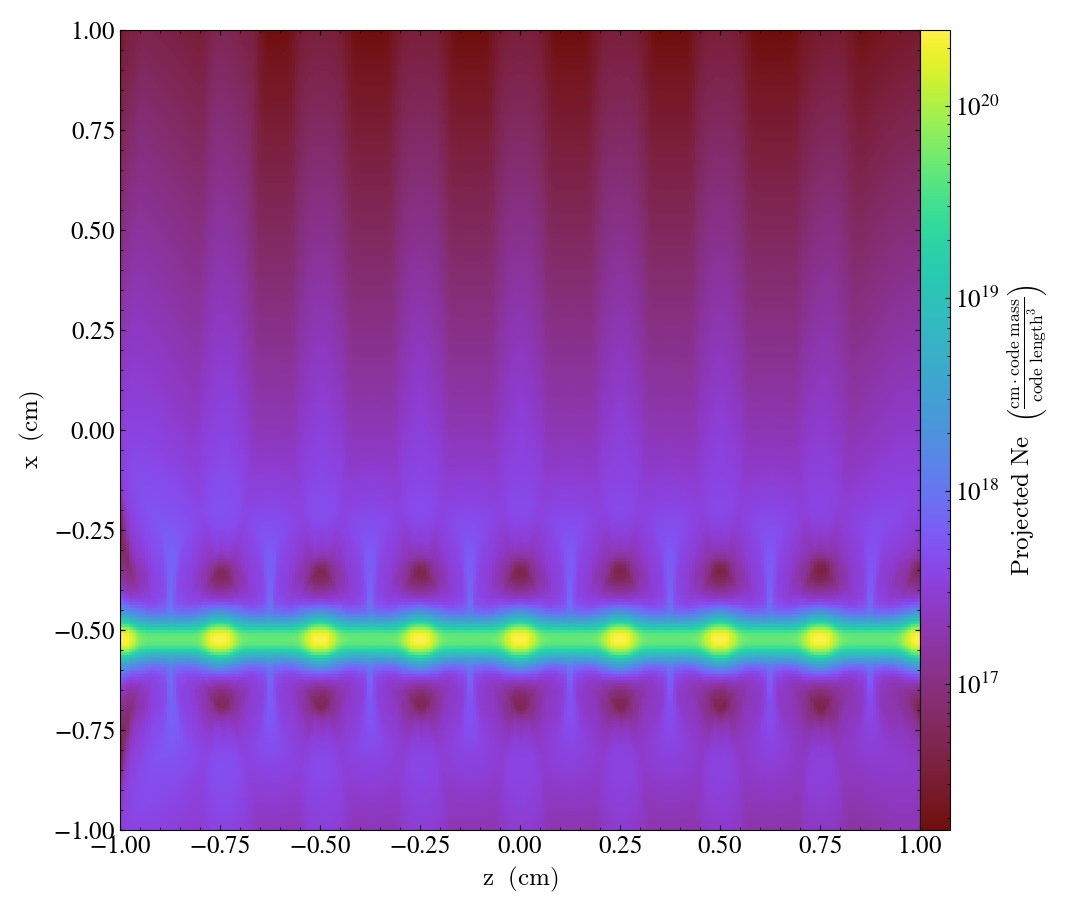

In [55]:
frm

In [46]:
int_dens = []
import csv
with open('/rds/general/user/le322/home/synthPy/analysis/final_data/interference_mesh/sh_new.csv', mode ='r')as file:
  csvFile = csv.reader(file)
  for lines in csvFile:
        int_dens.append(lines)
int_dens = np.array(int_dens, dtype = np.float64)
int_dens[np.where(int_dens == 'nan')] = 0


In [49]:
proj =proj[0]

In [58]:

# my_cmap = copy.copy(matplotlib.pyplot.get_cmap('turbo')) # copy the default cmap
# my_cmap.set_bad((0,0,0))
import matplotlib.ticker as ticker

def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)


plt.imshow(proj.T/(30),  
           cmap=('plasma'), extent = (0,2,0,2), origin = 'lower', clim = [0,2e17])

plt.xlim(0.25, 1.75)
plt.ylim(0.75, 1.25)
cb = plt.colorbar(fraction=0.02, pad=0.01, format=ticker.FuncFormatter(fmt))
cb.ax.minorticks_off()
plt.show()
plt.imshow(int_dens[50:350,80:400],
           cmap=('plasma'), extent = (0,2,0,2), origin = 'lower',  clim = [0,2e17])




cb = plt.colorbar(fraction=0.02, pad=0.01, format=ticker.FuncFormatter(fmt))
cb.ax.minorticks_off()
plt.xlim(0.25, 1.75)
plt.ylim(0.75, 1.25)



ValueError: operands could not be broadcast together with shapes (2000,2000) (300,320) 

In [68]:
(proj.T/(30)).mean(), np.nanmean(int_dens[50:350,80:400])

(1.0411076258919607e+18, 8.427559552936789e+16)

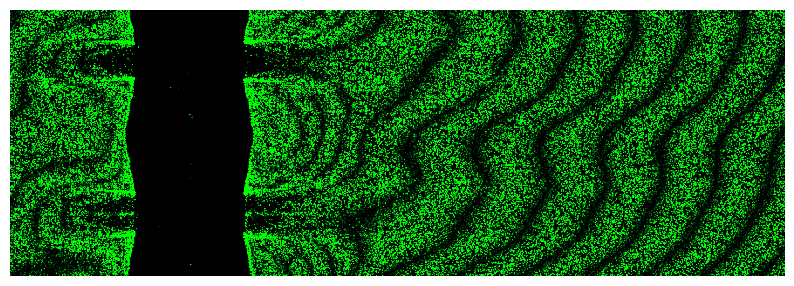

In [45]:
from matplotlib.colors import LinearSegmentedColormap
import pickle

sh = pickle.load(open("/rds/general/user/le322/home/synthPy/output/fluid sim/3D mesh/3dsim_interference_2_shadow.pkl", "rb"))

cdict1 = {
    'red': (
        (0.0, 0.0, 0.0),
        (0.5, 0.0, 0.0),
        (1.0, 0.0, 0.0),
    ),
    'green': (
        (0.0, 0.0, 0.0),
        (1.0, 1.0, 1.0),
    ),
    'blue': (
        (0.0, 0.0, 0.0),
        (0.5, 0.1, 0.0),
        (1.0, 0.0, 0.0),
    )
}
green = LinearSegmentedColormap('green', cdict1)

fig, ax = plt.subplots(figsize = (10,10))
ax.imshow(sh.H, clim = (0.0,0.5), cmap = green, extent = (0,18,0,13.5), origin = 'lower')
ax.set_xlim(4, 12)
ax.set_ylim(2.75,5.5)
ax.axis('off')
fig.show()

